Número total de modos utilizados: 10
Treinando um novo modelo...
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1867 - val_loss: 0.0997
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0869 - val_loss: 0.0932
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0697 - val_loss: 0.0861
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0615 - val_loss: 0.0789
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0537 - val_loss: 0.0716
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0497 - val_loss: 0.0643
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0435 - val_loss: 0.0510
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0402 - val_loss: 0.0456
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0377 - val_loss: 0.0409
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0365 - val_

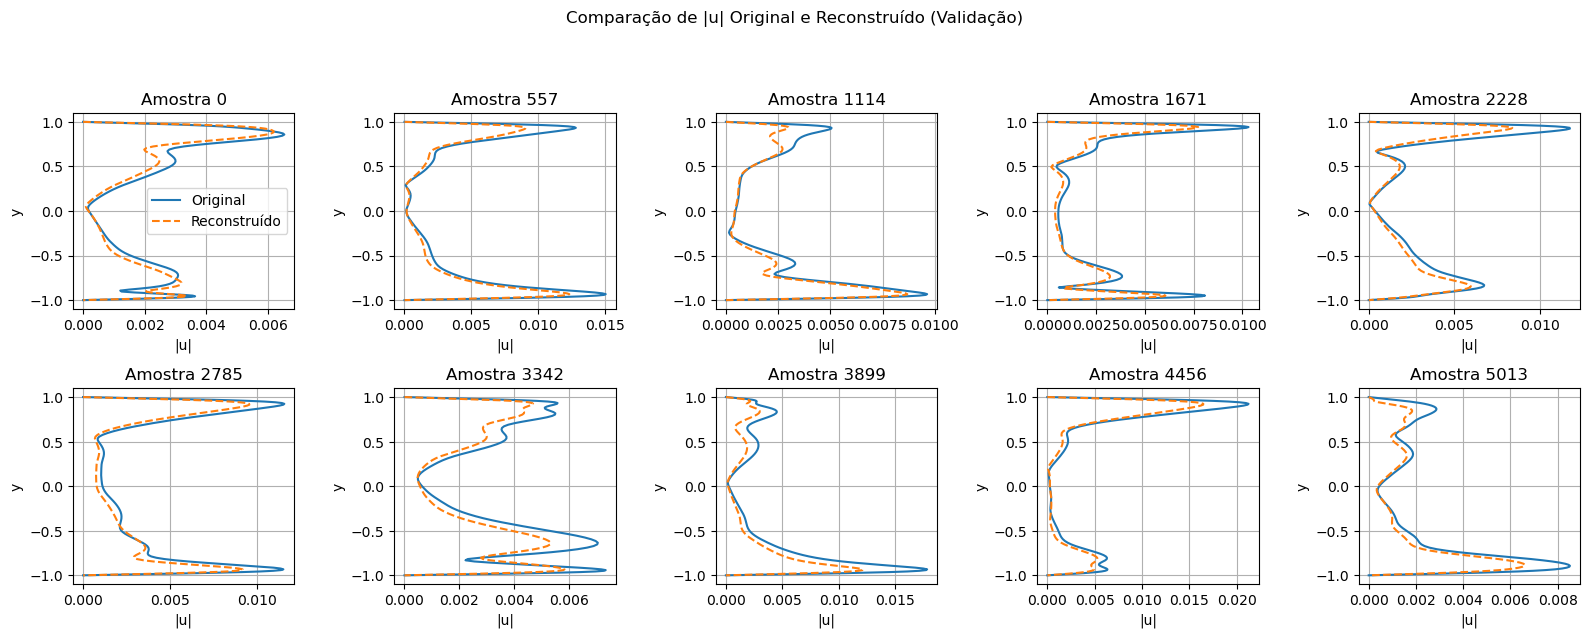

Métricas para a parte real:
MSE: 0.000000
MAE: 0.000217
Métricas para a parte imaginária:
MSE: 0.000000
MAE: 0.000211
Média do NMSE para a parte real: 0.057965
Média do NMSE para a parte imaginária: 0.050903
Média do NMSE para o módulo dos coeficientes: 0.195917


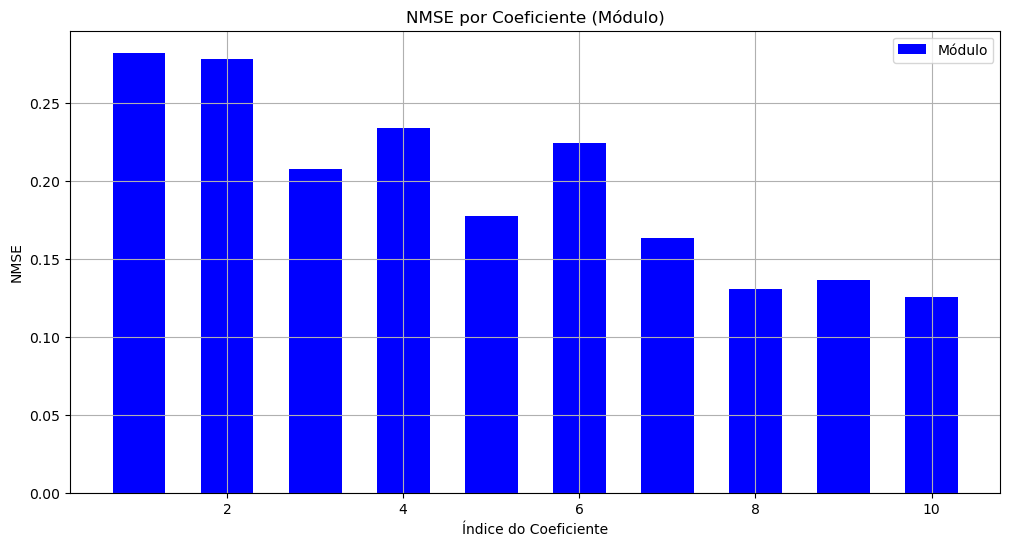

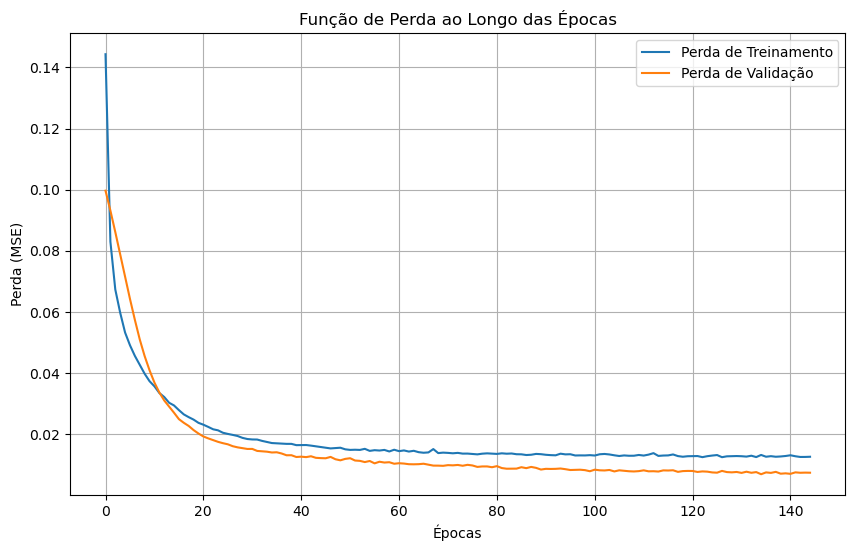

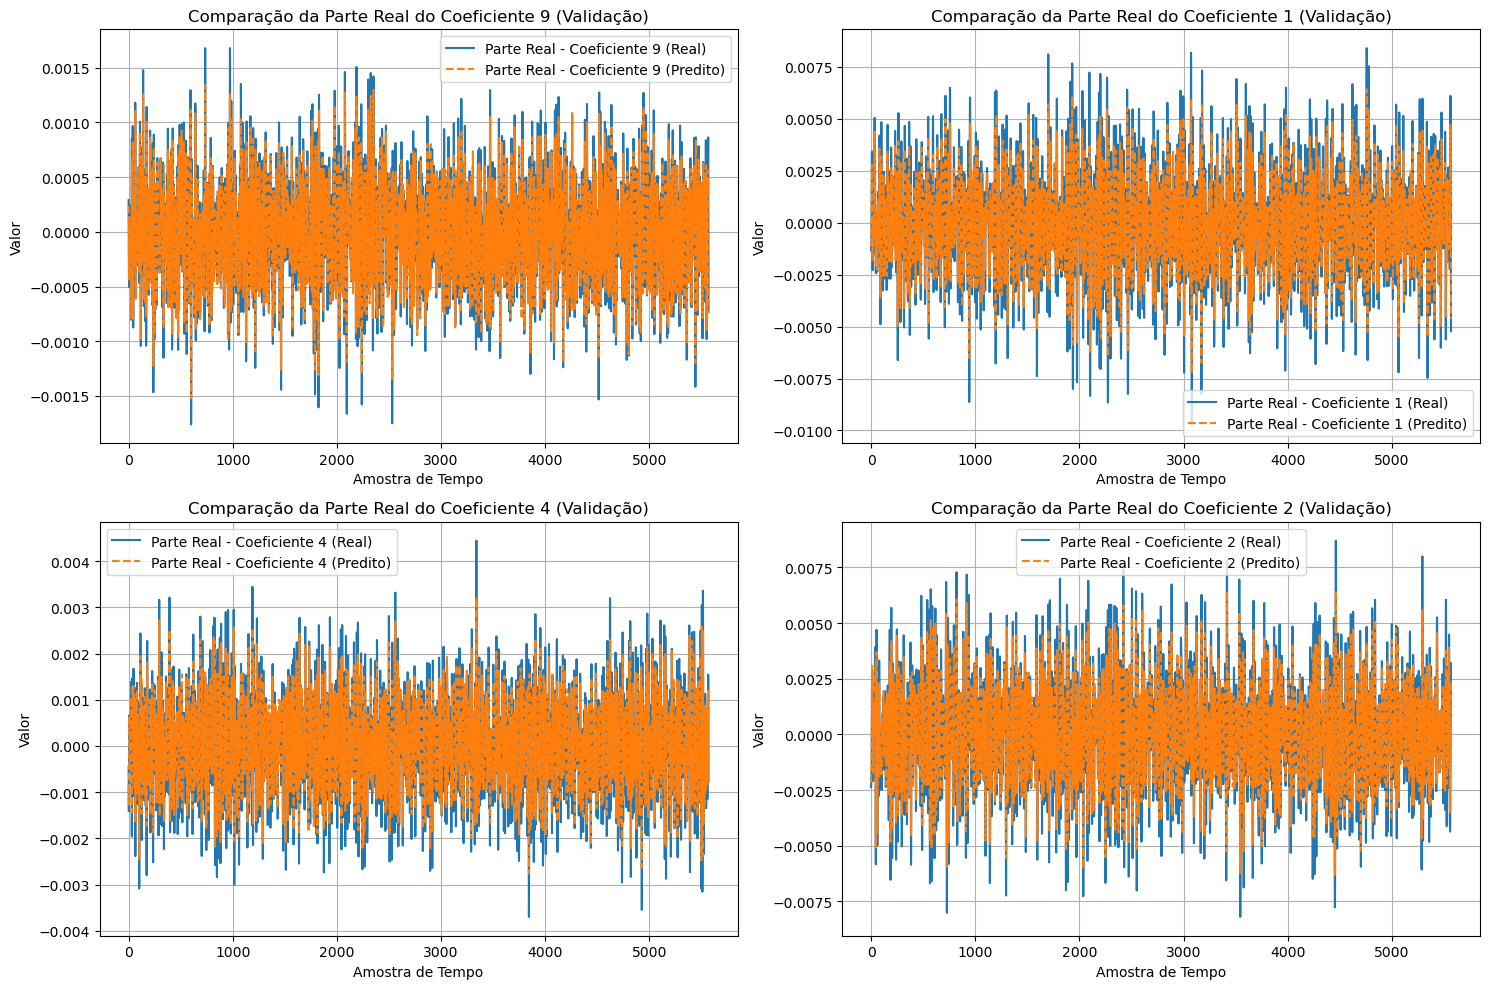

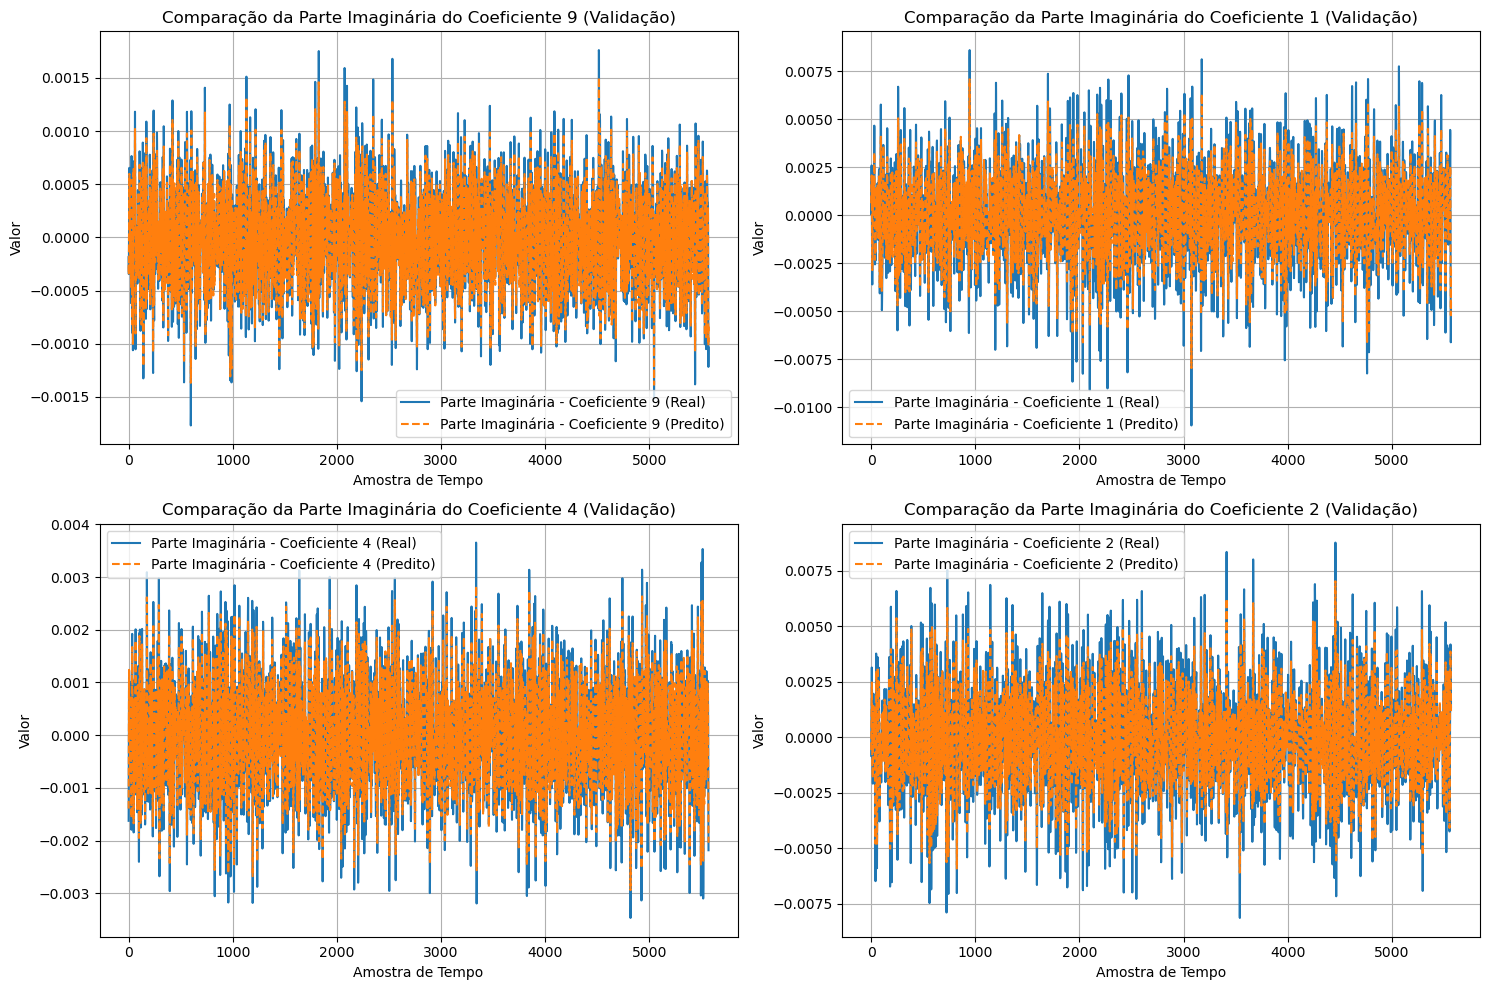

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Conv1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Atualizar os hiperparâmetros
hyperparams = {
    'model_path': 'modelo_cnn_gru_modificado.keras',
    'num_coefs': 10,
    'sequence_length': 30,  # Ajustado
    'gru_units': [128],  # Ajustado
    'conv_filters': [64, 32],  # Ajustado
    'kernel_size': 3,
    'dropout_rate': 0.2,  # Ajustado
    'l2_regularization': 0.0001,  # Ajustado
    'learning_rate': 0.001,  # Ajustado
    'epochs': 200,  # Ajustado
    'batch_size': 64,  # Ajustado
    'early_stopping_patience': 10  # Ajustado
}

# Carregar os arquivos .mat fornecidos
file_path_temp_coefs = "temp_coefs.mat"
file_path_spatial_modes = "spatial_modes.mat"
file_path_mean_flow = "mean_flow.mat"
file_path_parameters = "parameters.mat"

# Caminho para salvar/carregar o modelo
model_path = hyperparams['model_path']

# Carregar os coeficientes temporais
mat_data_temp = sio.loadmat(file_path_temp_coefs)
ts = mat_data_temp['ts'].flatten()  # Vetor de tempo
coefs = mat_data_temp['coefs']      # Matriz de coeficientes complexos

# Carregar os modos espaciais
mat_data_spatial = sio.loadmat(file_path_spatial_modes)
phi = mat_data_spatial['phi']       # Matriz de modos espaciais

# Carregar o vetor y e a média Xavg
mat_data_mean_flow = sio.loadmat(file_path_mean_flow)
y_positions = mat_data_mean_flow['y'].flatten()  # Vetor de posições espaciais y
Xavg = mat_data_mean_flow['Xavg'].flatten()      # Média do fluxo

# Carregar os modos usados no POD
mat_data_parameters = sio.loadmat(file_path_parameters)
nmodos_pod = mat_data_parameters['nmodes']       # Modos usados no POD

# Definir o número de coeficientes a serem utilizados
num_coefs = hyperparams['num_coefs']
print(f"Número total de modos utilizados: {num_coefs}")

# Separar os coeficientes em parte real e imaginária
real_coefs = np.real(coefs[:num_coefs, :])
imag_coefs = np.imag(coefs[:num_coefs, :])

# Definir o limite do primeiro intervalo
first_interval_end = 4801  # Posição correspondente ao tempo 1300

# Subamostragem do primeiro intervalo para taxa de 0.5 (pegando a cada 2 pontos)
real_coefs_train = real_coefs[:, :first_interval_end:2]
imag_coefs_train = imag_coefs[:, :first_interval_end:2]

# Segundo intervalo (já na taxa de 0.5)
real_coefs_val = real_coefs[:, first_interval_end:]
imag_coefs_val = imag_coefs[:, first_interval_end:]

# Concatenar as partes real e imaginária para normalização
coefs_train = np.vstack([real_coefs_train, imag_coefs_train])  # Dimensão (num_coefs*2, N_train)
coefs_val = np.vstack([real_coefs_val, imag_coefs_val])        # Dimensão (num_coefs*2, N_val)

# Normalizar os dados de treinamento individualmente para cada coeficiente usando MinMaxScaler
num_total_coefs = num_coefs * 2
scalers = []

coefs_train_normalized = np.zeros_like(coefs_train)
coefs_val_normalized = np.zeros_like(coefs_val)

for i in range(num_total_coefs):
    scaler_coef = MinMaxScaler(feature_range=(-1, 1))
    coefs_train_normalized[i, :] = scaler_coef.fit_transform(coefs_train[i, :].reshape(-1, 1)).flatten()
    coefs_val_normalized[i, :] = scaler_coef.transform(coefs_val[i, :].reshape(-1, 1)).flatten()
    scalers.append(scaler_coef)

# Separar novamente as partes real e imaginária normalizadas
real_coefs_train_normalized = coefs_train_normalized[:num_coefs, :]
imag_coefs_train_normalized = coefs_train_normalized[num_coefs:, :]
real_coefs_val_normalized = coefs_val_normalized[:num_coefs, :]
imag_coefs_val_normalized = coefs_val_normalized[num_coefs:, :]

# Definir o comprimento da sequência para a GRU
sequence_length = hyperparams['sequence_length']

# Função para criar sequências de entrada e saídas correspondentes (previsão de um passo à frente)
def create_sequences(real_coefs_norm, imag_coefs_norm, seq_length):
    X = []
    y = []
    num_samples = real_coefs_norm.shape[1] - seq_length
    for i in range(num_samples):
        # Sequências das partes real e imaginária
        X_seq_real = real_coefs_norm[:, i:i+seq_length]
        X_seq_imag = imag_coefs_norm[:, i:i+seq_length]
        X_seq = np.vstack([X_seq_real, X_seq_imag])  # Dimensão (num_coefs*2, seq_length)
        X.append(X_seq)
        # Saídas: próximo coeficiente após a sequência
        y_real = real_coefs_norm[:, i+seq_length]
        y_imag = imag_coefs_norm[:, i+seq_length]
        y_seq = np.hstack([y_real, y_imag])  # Dimensão (num_coefs*2,)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    # Ajustar as dimensões para [samples, timesteps, features]
    X = X.transpose(0, 2, 1)  # [samples, timesteps, features]
    return X, y

# Preparar os dados de treinamento
X_train, y_train = create_sequences(real_coefs_train_normalized, imag_coefs_train_normalized, sequence_length)

# Preparar os dados de validação
X_val, y_val = create_sequences(real_coefs_val_normalized, imag_coefs_val_normalized, sequence_length)

# Verificar se o modelo já foi salvo anteriormente
retrain_model = True
if os.path.exists(model_path):
    print("Carregando o modelo salvo...")
    model = load_model(model_path)
    if model.input_shape[1:] != (X_train.shape[1], X_train.shape[2]):
        print("O modelo salvo não é compatível com os dados atuais. Treinando um novo modelo.")
        os.remove(model_path)
        retrain_model = True
    else:
        retrain_model = False
else:
    print("Treinando um novo modelo...")
    retrain_model = True

if retrain_model:
    # Definir o modelo CNN+GRU com regularização
    gru_input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # [timesteps, features]

    x = gru_input  # Forma: (batch_size, timesteps, features)

    # Aplicar Conv1D diretamente sobre a dimensão temporal
    x = Conv1D(filters=hyperparams['conv_filters'][0],
               kernel_size=hyperparams['kernel_size'],
               activation='relu', padding='same',
               kernel_regularizer=l2(hyperparams['l2_regularization']))(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=hyperparams['conv_filters'][1],
               kernel_size=hyperparams['kernel_size'],
               activation='relu', padding='same',
               kernel_regularizer=l2(hyperparams['l2_regularization']))(x)
    x = BatchNormalization()(x)
    x = Dropout(hyperparams['dropout_rate'])(x)

    # Camada GRU
    x = GRU(hyperparams['gru_units'][0], return_sequences=False, activation='tanh',
            kernel_regularizer=l2(hyperparams['l2_regularization']),
            recurrent_dropout=hyperparams['dropout_rate'])(x)
    x = Dropout(hyperparams['dropout_rate'])(x)

    # Camada de saída
    output = Dense(num_coefs * 2, activation='linear',
                   kernel_regularizer=l2(hyperparams['l2_regularization']))(x)

    # Definir e compilar o modelo
    model = Model(inputs=gru_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=hyperparams['learning_rate']), loss='mean_squared_error')

    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparams['early_stopping_patience'],
                                   restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model_gru.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Treinar o modelo
    history = model.fit(X_train, y_train,
                        epochs=hyperparams['epochs'],
                        batch_size=hyperparams['batch_size'],
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpoint],
                        verbose=1)

    # Salvar o modelo treinado
    model.save(model_path)
else:
    print("Usando o modelo salvo para fazer previsões.")

# Fazer previsões no conjunto de validação
predictions_normalized = model.predict(X_val)

# Reverter a normalização para cada coeficiente
predictions = np.zeros_like(predictions_normalized)
y_val_original = np.zeros_like(y_val)
for i in range(num_total_coefs):
    scaler = scalers[i]
    predictions[:, i] = scaler.inverse_transform(predictions_normalized[:, i].reshape(-1, 1)).flatten()
    y_val_original[:, i] = scaler.inverse_transform(y_val[:, i].reshape(-1, 1)).flatten()

# Separar as partes real e imaginária
pred_real = predictions[:, :num_coefs]
pred_imag = predictions[:, num_coefs:]
actual_real = y_val_original[:, :num_coefs]
actual_imag = y_val_original[:, num_coefs:]

# Reconstruir os coeficientes complexos preditos e reais
predicted_coefs = pred_real + 1j * pred_imag
actual_coefs = actual_real + 1j * actual_imag

# Reconstruir X a partir dos coeficientes preditos e dos modos espaciais
phi_reduced = phi[:, :num_coefs]  # Dimensão (387, num_coefs)
Xavg = Xavg.flatten()  # Dimensão (387,)

X_rec_list = []
X_actual_list = []

for i in range(predicted_coefs.shape[0]):
    # Reconstrução predita
    X_rec = Xavg + phi_reduced @ predicted_coefs[i]
    X_rec_list.append(X_rec)
    # Reconstrução real
    X_actual = Xavg + phi_reduced @ actual_coefs[i]
    X_actual_list.append(X_actual)

# Converter as listas em arrays e transpor
X_rec_array = np.array(X_rec_list).T        # Forma (387, num_samples)
X_actual_array = np.array(X_actual_list).T  # Forma (387, num_samples)

# Número de pontos em y
ny = y_positions.shape[0]  # Deve ser 129

# Plotar a comparação entre os perfis originais e reconstruídos de |u|
step = 10  # Número de subplots (ajuste conforme necessário)

plt.figure(figsize=(16, 12))
plt.clf()
for i in range(step):
    plt.subplot(4, 5, i + 1)
    # Índice do tempo
    idx = i * (X_rec_array.shape[1] // step)
    plt.plot(np.abs(X_actual_array[:ny, idx]), y_positions, label='Original')
    plt.plot(np.abs(X_rec_array[:ny, idx]), y_positions, label='Reconstruído', linestyle='--')
    plt.xlabel('|u|')
    plt.ylabel('y')
    plt.title(f'Amostra {idx}')
    plt.grid(True)
    if i == 0:
        plt.legend()
plt.suptitle('Comparação de |u| Original e Reconstruído (Validação)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calcular as métricas de erro separadamente para as partes real e imaginária
mse_real = mean_squared_error(actual_real.flatten(), pred_real.flatten())
mae_real = mean_absolute_error(actual_real.flatten(), pred_real.flatten())
mse_imag = mean_squared_error(actual_imag.flatten(), pred_imag.flatten())
mae_imag = mean_absolute_error(actual_imag.flatten(), pred_imag.flatten())

print(f"Métricas para a parte real:")
print(f"MSE: {mse_real:.6f}")
print(f"MAE: {mae_real:.6f}")

print(f"Métricas para a parte imaginária:")
print(f"MSE: {mse_imag:.6f}")
print(f"MAE: {mae_imag:.6f}")

# Função para calcular NMSE por coeficiente
def calculate_normalized_mse(actual, predicted):
    num_coefs = actual.shape[1]
    nmse = np.zeros(num_coefs)
    for c in range(num_coefs):
        mse = mean_squared_error(actual[:, c], predicted[:, c])
        variance = np.var(actual[:, c])
        # Evitar divisão por zero
        if variance != 0:
            nmse[c] = mse / variance
        else:
            nmse[c] = np.nan  # ou trate conforme apropriado
    return nmse

# Calcular NMSE para a parte real
nmse_real = calculate_normalized_mse(actual_real, pred_real)

# Calcular NMSE para a parte imaginária
nmse_imag = calculate_normalized_mse(actual_imag, pred_imag)

# Calcular NMSE para o módulo dos coeficientes
actual_modulus = np.sqrt(actual_real**2 + actual_imag**2)
predicted_modulus = np.sqrt(pred_real**2 + pred_imag**2)
nmse_modulus = calculate_normalized_mse(actual_modulus, predicted_modulus)

# Calcular a média do NMSE sobre todos os coeficientes
average_nmse_real = np.nanmean(nmse_real)
average_nmse_imag = np.nanmean(nmse_imag)
average_nmse_modulus = np.nanmean(nmse_modulus)

print(f"Média do NMSE para a parte real: {average_nmse_real:.6f}")
print(f"Média do NMSE para a parte imaginária: {average_nmse_imag:.6f}")
print(f"Média do NMSE para o módulo dos coeficientes: {average_nmse_modulus:.6f}")

# Plotar NMSE do Módulo por coeficiente
coefficients = np.arange(1, num_coefs + 1)

plt.figure(figsize=(12, 6))
plt.bar(coefficients, nmse_modulus, width=0.6, label='Módulo', color='blue')
plt.xlabel('Índice do Coeficiente')
plt.ylabel('NMSE')
plt.title('NMSE por Coeficiente (Módulo)')
plt.legend()
plt.grid(True)
plt.show()

# Plotar a função de perda (loss) ao longo das épocas
if retrain_model:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Função de Perda ao Longo das Épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Perda (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar coeficientes aleatórios em subplots
num_plots = 4  # Número de coeficientes a serem plotados
random_indices = np.random.choice(num_coefs, num_plots, replace=False)

plt.figure(figsize=(15, 10))
for idx, coef_index in enumerate(random_indices):
    plt.subplot(2, 2, idx + 1)
    plt.plot(actual_real[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Real)')
    plt.plot(pred_real[:, coef_index], label=f'Parte Real - Coeficiente {coef_index+1} (Predito)', linestyle='--')
    plt.title(f'Comparação da Parte Real do Coeficiente {coef_index+1} (Validação)')
    plt.xlabel('Amostra de Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for idx, coef_index in enumerate(random_indices):
    plt.subplot(2, 2, idx + 1)
    plt.plot(actual_imag[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Real)')
    plt.plot(pred_imag[:, coef_index], label=f'Parte Imaginária - Coeficiente {coef_index+1} (Predito)', linestyle='--')
    plt.title(f'Comparação da Parte Imaginária do Coeficiente {coef_index+1} (Validação)')
    plt.xlabel('Amostra de Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
